<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Mining-multiple-pathogen-host-protein-interactomes-for-the-detection-of-shared-patterns." data-toc-modified-id="Mining-multiple-pathogen-host-protein-interactomes-for-the-detection-of-shared-patterns.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Mining multiple pathogen-host protein interactomes for the detection of shared patterns.</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introduction</a></span></li></ul></li><li><span><a href="#Data-collection-and-exploration" data-toc-modified-id="Data-collection-and-exploration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data collection and exploration</a></span><ul class="toc-item"><li><span><a href="#Protein-protein-interaction-data-sources" data-toc-modified-id="Protein-protein-interaction-data-sources-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Protein-protein interaction data sources</a></span><ul class="toc-item"><li><span><a href="#Data-filtering-and-clean-up" data-toc-modified-id="Data-filtering-and-clean-up-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Data filtering and clean-up</a></span></li><li><span><a href="#Quality-of-interactions" data-toc-modified-id="Quality-of-interactions-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Quality of interactions</a></span></li><li><span><a href="#Taxonomic-diversity-of-data-set" data-toc-modified-id="Taxonomic-diversity-of-data-set-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Taxonomic diversity of data set</a></span><ul class="toc-item"><li><span><a href="#Inter-viral-interactions" data-toc-modified-id="Inter-viral-interactions-2.1.3.1"><span class="toc-item-num">2.1.3.1&nbsp;&nbsp;</span>Inter-viral interactions</a></span></li></ul></li><li><span><a href="#Protein-diversity" data-toc-modified-id="Protein-diversity-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>Protein diversity</a></span></li></ul></li><li><span><a href="#Annotation-data" data-toc-modified-id="Annotation-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Annotation data</a></span><ul class="toc-item"><li><span><a href="#Gene-Ontology" data-toc-modified-id="Gene-Ontology-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Gene Ontology</a></span></li><li><span><a href="#InterPro" data-toc-modified-id="InterPro-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>InterPro</a></span></li></ul></li><li><span><a href="#Examining-the-resulting-data" data-toc-modified-id="Examining-the-resulting-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Examining the resulting data</a></span></li><li><span><a href="#Some-caveats..." data-toc-modified-id="Some-caveats...-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Some caveats...</a></span></li><li><span><a href="#Potential-improvements-in-data-filtering-and-validation" data-toc-modified-id="Potential-improvements-in-data-filtering-and-validation-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Potential improvements in data filtering and validation</a></span></li></ul></li><li><span><a href="#Frequent-item-set-mining" data-toc-modified-id="Frequent-item-set-mining-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Frequent item set mining</a></span><ul class="toc-item"><li><span><a href="#Creation-of-pairwise-sub-rules" data-toc-modified-id="Creation-of-pairwise-sub-rules-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Creation of pairwise sub-rules</a></span></li><li><span><a href="#Visualisation-of-association-rules" data-toc-modified-id="Visualisation-of-association-rules-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Visualisation of association rules</a></span></li></ul></li><li><span><a href="#Some-more-caveats" data-toc-modified-id="Some-more-caveats-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Some more caveats</a></span></li><li><span><a href="#Some-more-unexplored-options" data-toc-modified-id="Some-more-unexplored-options-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Some more unexplored options</a></span></li><li><span><a href="#References" data-toc-modified-id="References-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Mining multiple pathogen-host protein interactomes for the detection of shared patterns.
## Introduction
The interplay between intracellular pathogens and their hosts is mediated through intricate molecular interactions. Protein-protein interactions (PPI) make up a large part of this process and gaining a deeper insight into this facet of infectious diseases will help us in our fight against various pathogens.

We set out to study the interactomes of *Herpesviridae* and their hosts by utilizing frequent item set mining and association rule mining. We aim to develop a generic methodology that can analyse host-pathogen networks with the goal of discovering and describing shared characteristics, pathogen strategies or host-pathogen relations at the protein level.

**This is an informal report to briefly describe the methodology and results of this project.**

# Data collection and exploration

In [1]:
import os, sys
# setup correct path to script files
from pathlib import Path
my_file = Path("main.py")
if not my_file.is_file():
    import sys,os
    os.chdir('../src/ppi_tools/')
    sys.path.append('../src/')
sys.path.append(os.path.abspath('..'))    

import argparse
import collections
from pathlib import Path

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
from IPython.display import display, HTML # pretty tables
from IPython.display import Image # local images
from IPython.core.display import HTML 

import id_mapper
import label_go
import label_interpro
import ppi_import
from data_prep import retrieve_taxids
from go_tools import gaf_parser
from go_tools import obo_tools
from main import *

# run main script to annotate and convert PPI datasets into a format suitable for frequent item set mining.
# and suppress output
# %run main.py -d

## Protein-protein interaction data sources
The protein-protein interaction (PPI) datasets were retrieved from the following sources.

- The HPIDB 2.0 dataset was retrieved from: [http://www.agbase.msstate.edu/hpi/downloads/hpidb2.mitab.zip]. [^fn1]
- The VirHostNet 2.0 dataset is available from: [http://virhostnet.prabi.fr/] (release January 2017).[^fn2]
- The PHISTO dataset was obtained from [http://www.phisto.org/index.xhtml] by using the browse utility (Data update: January 19, 2017).[^fn3]
- The PSI-MI ontology .obo file was downloaded from [http://ontologies.berkeleybop.org/mi.obo] (data-version: releases/2017-06-14).[^fn4]

The different primary data sources in these databases are:

In [2]:
%%bash
printf 'HPIDB2:\n'
cat <(tail -n +2 ../../data/raw/ppi_data/hpidb2_March14_2017_mitab.txt | cut -f1) <(tail -n +2 ../../data/raw/ppi_data/hpidb2_March14_2017_mitab.txt | cut -f2) | sed -r 's/(^.*?):.*/\1/g' | sort -u
printf "\nVirHostNet:\n"
cat <(tail -n +2 ../../data/raw/ppi_data/VirHostNet_January_2017.txt | cut -f1) <(tail -n +2 ../../data/raw/ppi_data/VirHostNet_January_2017.txt | cut -f2) | sed -r 's/(^.*?):.*/\1/g' | sort -u
printf "\nIntAct:\n"
cat <(tail -n +2 ../../data/raw/ppi_data/intact_virus_2017_12_1.txt| cut -f1) <(tail -n +2 ../../data/raw/ppi_data/intact_virus_2017_12_1.txt | cut -f2) | sed -r 's/(^.*?):.*/\1/g' | sort -u


HPIDB2:
ddbj/embl/genbank
ensembl
ensemblgenomes
entrez gene/locuslink
intact
refseq
uniprotkb

VirHostNet:
refseq
uniprotkb

IntAct:
-
chebi:"CHEBI
ddbj/embl/genbank
dip
intact
refseq
uniprotkb


- HPIDB2:
    - ddbj/embl/genbank
    - ensembl
    - ensemblgenomes
    - entrez gene/locuslink
    - intact
    - refseq
    - uniprotkb
- VirHostNet:
    - refseq
    - uniprotkb
- IntAct:
    - -
    - chebi:"CHEBI
    - ddbj/embl/genbank
    - dip
    - intact
    - refseq
    - uniprotkb

More information about the MITAB format used by HPIDB2 and VirHostNet can be found at: https://psicquic.github.io/MITAB27Format.html.

### Data filtering and clean-up

All PPIs pertaining to the Herpesviridae familiy were extracted from the above PPI datasets.

In [3]:
%%capture

# create taxid dictionary for Herpesviridae
name2taxid, taxid2name = retrieve_taxids.parse_taxid_names(r'../../data/raw/taxdump/names.dmp')
with Path(r'../../data/interim/child_taxids_of_10292.txt').open() as taxid_file:
        herpes_taxids = [str('taxid:' + line.split('|')[0]) for line in taxid_file]

# Import PPI datasets
df_virhost = ppi_import.read_mitab_virhost(r'../../data/raw/ppi_data/VirHostNet_January_2017.txt')
df_hpidb2 = ppi_import.read_psi_mi_tab(r'../../data/raw/ppi_data/hpidb2_March14_2017_mitab_plus.txt', 'hpidb2')
df_phisto = ppi_import.read_mitab_phisto(r'../../data/raw/ppi_data/phisto_Jan19_2017.csv',
                                         r'../../data/raw/ppi_data/mi.obo')
df_intact = ppi_import.read_psi_mi_tab(r'../../data/raw/ppi_data/intact_virus_2017_12_1.txt', 'intact')
df_concat = concat_interaction_datasets([df_hpidb2, df_virhost, df_phisto, df_intact])

# filter on Herpesviridae
df_herpes = df_concat.loc[(df_concat.taxid_A.isin(herpes_taxids)) | df_concat.taxid_B.isin(herpes_taxids)]
df_herpes = df_herpes.reset_index(drop=True)

# create combined identifier
xref_partners_sorted_array = np.sort(np.stack((df_herpes.xref_A, df_herpes.xref_B), axis=1), axis=1)
xref_partners_df = pd.DataFrame(xref_partners_sorted_array, columns=['A', 'B'])
df_herpes['xref_partners_sorted'] = xref_partners_df['A'] + '%' + xref_partners_df['B']

In [4]:
display(df_herpes.groupby('origin').size())

origin
PHISTO         7946
VirHostNet2    5446
hpidb2         8231
intact         4529
dtype: int64

Duplicated entries were removed. One example of duplicate PPI entries could be those for which the same two proteins interact, but which differ in pathogen sources (because strains share proteins), publication or experimental method. Whenever possible, the HPIDB2 entries were preferentially retained.

Overall, these data sets also exhibit a substantial amount of overlap between them, since both the VirHostNet2 and PHISTO data sets were substantially reduced after this operation.

In [6]:
duplicates = df_herpes.origin[df_herpes.duplicated(subset=['xref_partners_sorted'])].groupby(df_herpes.origin).size()
uniques = df_herpes.origin[~df_herpes.duplicated(subset=['xref_partners_sorted'])].groupby(df_herpes.origin).size()
display(duplicates)
display(uniques)
duplicates.index
display(total)



origin
PHISTO         7111
VirHostNet2    4351
hpidb2         1373
intact         3104
Name: origin, dtype: int64

origin
PHISTO          835
VirHostNet2    1095
hpidb2         6858
intact         1425
Name: origin, dtype: int64

NameError: name 'total' is not defined

In [7]:
height

NameError: name 'height' is not defined

origin
PHISTO          835
VirHostNet2    1095
hpidb2         6858
intact         1425
Name: origin, dtype: int64

origin
PHISTO         7946
VirHostNet2    5446
hpidb2         8231
intact         4529
Name: origin, dtype: int64

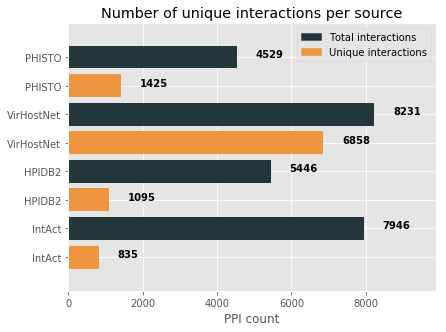

In [8]:
duplicates = df_herpes.origin[df_herpes.duplicated(subset=['xref_partners_sorted'])].groupby(df_herpes.origin).size()
uniques = df_herpes.origin[~df_herpes.duplicated(subset=['xref_partners_sorted'])].groupby(df_herpes.origin).size()
total = df_herpes.origin.groupby(df_herpes.origin).size()

display(uniques)
display(total)

# inter-intra plot
height = [val for pair in zip(uniques, total) for val in pair]
bars = [val for pair in zip(uniques.index, total.index) for val in pair]
bars = ['IntAct', 'IntAct', 'HPIDB2', 'HPIDB2', 'VirHostNet', 'VirHostNet', 'PHISTO', 'PHISTO']
y_pos = np.arange(len(bars))
plt.barh(y_pos, height, color=('#ee953f', '#23373b')) # #ee953f orange #23373b teal
plt.yticks(y_pos, bars)
for i in range(len(y_pos)):
    plt.text(x = height[i]+500 , y = y_pos[i], s = height[i], size = 10, fontweight = 'bold')
plt.tight_layout(pad=0)
plt.margins(0.2, 0.1)
# plt.subplots_adjust(right=2.3)
plt.title('Number of unique interactions per source')
plt.xlabel('PPI count')
import matplotlib.patches as mpatches
u = mpatches.Patch(color='#ee953f', label='Unique interactions')
t = mpatches.Patch(color='#23373b', label='Total interactions')
plt.legend(handles=[t, u], loc=1)
plt.savefig('../../data/processed/img/redundancy.pdf', facecolor='#fafafa', edgecolor='none', bbox_inches='tight')
plt.show()


In [9]:
print(np.sum(df_herpes.duplicated(subset=['xref_partners_sorted'])), 'duplicated PPIs were removed.')
df_herpes = df_herpes.drop_duplicates(subset=['xref_partners_sorted'], keep='first')
df_herpes = df_herpes.reset_index(drop=True)
display(df_herpes.groupby('origin').size())

15939 duplicated PPIs were removed.


origin
PHISTO          835
VirHostNet2    1095
hpidb2         6858
intact         1425
dtype: int64

Only inter-species PPIs were retained.

Original data set size: 10213 
Only inter-species PPI: 8798 
Number of removed PPIs: 1415


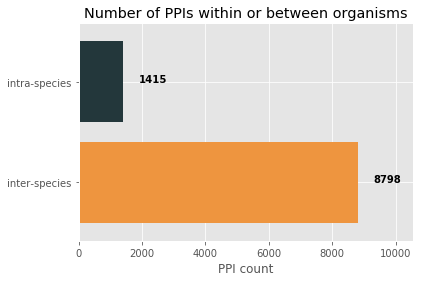

In [10]:
annotate_inter_intra(df_herpes)
df_inter_intra = df_herpes.copy()
df_herpes = df_herpes[df_herpes['inter-intra'] == 'inter-species']
df_herpes = df_herpes.reset_index(drop=True)
print('Original data set size:', df_inter_intra.shape[0], '\nOnly inter-species PPI:', 
      df_herpes.shape[0], '\nNumber of removed PPIs:', df_inter_intra.shape[0] - df_herpes.shape[0])

# inter-intra plot
height = df_inter_intra.groupby('inter-intra').size()
bars = df_inter_intra.groupby('inter-intra').size().index
y_pos = np.arange(len(bars))
plt.barh(y_pos, height, color=('#ee953f', '#23373b')) # #ee953f orange #23373b teal
plt.yticks(y_pos, bars)
for i in range(len(y_pos)):
    plt.text(x = height[i]+500 , y = y_pos[i], s = height[i], size = 10, fontweight = 'bold')
# plt.tight_layout(pad=0)
plt.margins(0.2, 0.1)
# plt.subplots_adjust(right=2.3)
plt.title('Number of PPIs within or between organisms')
plt.xlabel('PPI count')
plt.show()

All protein identifiers were mapped to `UniProtKB`s, except for a number of `intact:EBI`s, `entrez gene/locuslink`s  and `refseq`s for which no corresponding UniProtKB was found.

88 + 167 additional PPIs were removed because a) no valid mapping to UniProt accession numbers were found or b) multiple mappings were found. Retaining the latter would artificially inflate counts during frequent item set mining. 

In [11]:
id_mapper.map2uniprot(df_herpes, filepath=r'../../data/interim/mappings/')
df_herpes = id_mapper.remove_mult(df_herpes)

## adding
df_herpes.reset_index(inplace=True, drop=True)


unmapped = df_herpes.loc[~(df_herpes['xref_A'].str.contains('uniprotkb:') &
                           df_herpes['xref_B'].str.contains('uniprotkb:'))]
print('Unmapped proteins:',unmapped.shape[0])
df_herpes = df_herpes.loc[(df_herpes['xref_A'].str.contains('uniprotkb:') & # only select remapped entries
                           df_herpes['xref_B'].str.contains('uniprotkb:'))] 
# TO THIS BEFORE CREATING
df_herpes.reset_index(inplace=True, drop=True)
# re-create combined identifier
xref_partners_sorted_array = np.sort(np.stack((df_herpes.xref_A, df_herpes.xref_B), axis=1), axis=1)
xref_partners_df = pd.DataFrame(xref_partners_sorted_array, columns=['A', 'B'])
df_herpes['xref_partners_sorted'] = xref_partners_df['A'] + '%' + xref_partners_df['B']

Converted all found identifiers to UniProt ACs.
Omitted 167 PPIs due to the existance of multiple mappings.
Unmapped proteins: 88


Surprisingly, the re-mapping resulted in a number of new duplicates!

In [12]:
print(np.sum(df_herpes.duplicated(subset=['xref_partners_sorted'])), 'duplicated PPIs were removed.')
df_herpes = df_herpes.drop_duplicates(subset=['xref_partners_sorted'], keep='first')
df_herpes = df_herpes.reset_index(drop=True)

295 duplicated PPIs were removed.


For example, the following interaction was catalogued once for _Human herpesvirus 8 strain GK18_ and once for the higher order _Human gammaherpesvirus 8_. These issues could be resolved by filtering on both PPI partners **and** their taxids.

In [13]:
display(df_herpes.loc[df_herpes.xref_partners_sorted=='uniprotkb:Q13547%uniprotkb:Q2HR82'])
display(df_concat.loc[df_concat.interaction_identifiers=='biogrid:669512'])
display(df_concat.loc[df_concat.interaction_identifiers=='intact:EBI-9006990|imex:IM-21800-6'])

,Annotation(s) interactor A,Annotation(s) interactor B,Biological role(s) interactor A,Biological role(s) interactor B,Checksum(s) interactor A,Checksum(s) interactor B,Creation date,Expansion method(s),Experimental role(s) interactor A,Experimental role(s) interactor B,Feature(s) interactor A,Feature(s) interactor B,Host organism(s),Identification method participant A,Identification method participant B,Interaction Checksum(s),Interaction Xref(s),Interaction annotation(s),Interaction parameter(s),Negative,Stoichiometry(s) interactor A,Stoichiometry(s) interactor B,Type(s) interactor A,Type(s) interactor B,Update date,Xref(s) interactor A,Xref(s) interactor B,aliases_A,aliases_B,alt_identifiers_A,alt_identifiers_B,author,confidence_score,detection_method,display_id_A,display_id_B,interaction_identifiers,interaction_type,origin,pathogen,protein_seq1,protein_seq2,protein_taxid_1_cat,protein_taxid_1_name,protein_taxid_2_cat,protein_taxid_2_name,protein_xref_1_display_id,protein_xref_1_unique,protein_xref_2_display_id,protein_xref_2_unique,publication,source_database,source_database_ids,taxid_A,taxid_B,xref_A,xref_B,xref_partners_sorted,inter-intra
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,psi-mi:hdac1_human(display_long)|uniprotkb:HDAC1(gene name)|psi-mi:HDAC1(display_short)|uniprotkb:RPD3L1(gene name synonym),psi-mi:kbzip_hhv8p(display_long)|uniprotkb:K8(gene name)|psi-mi:K8(display_short),intact:EBI-301834|uniprotkb:Q92534,intact:EBI-9006943,Martínez et al. (2012),intact-miscore:0.43,psi-mi:MI:0006(anti bait coimmunoprecipitation),NaN,NaN,intact:EBI-9006990|imex:IM-21800-6,psi-mi:MI:0914(association),hpidb2,NaN,MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLNYGLYRKMEIYRPHKANAEEMTKYHSDDYIKFLRSIRPDNMSEYSKQMQRFNVGEDCPVFDGLFEFCQLSTGGSVASAVKLNKQQTDIAVNWAGGLHHAKKSEASGFCYVNDIVLAILELLKYHQRVLYIDIDIHHGDGVEEAFYTTDRVMTV...,MPRMKDIPTKSSPGTDNSEKDEAVIEEDLSLNGQPFFTDNTDGGENEVSWTSSLLSTYVGCQPPAIPVCETVIDLTAPSQSGAPGDEHLPCSLNAETKFHIPDPSWTLSHTPPRGPHISQQLPTRRSKRRLHRKFEEERLCTKAKQGAGRPVPASVVKVGNITPHYGEELTRGDAVPAAPITPPYPRVQRPAQPTH...,ANIMAL,human|Homo sapiens,VIRUS,hhv8p|Human herpesvirus 8,HDAC1_HUMAN,UNIPROT_AC:Q13547,KBZIP_HHV8P,UNIPROT_AC:Q2HR82,pubmed:22416134|imex:IM-21800,UniProt,psi-mi:MI:0486(UniProt),taxid:9606,taxid:868565,uniprotkb:Q13547,uniprotkb:Q2HR82,uniprotkb:Q13547%uniprotkb:Q2HR82,inter-species


,Annotation(s) interactor A,Annotation(s) interactor B,Biological role(s) interactor A,Biological role(s) interactor B,Checksum(s) interactor A,Checksum(s) interactor B,Creation date,Expansion method(s),Experimental role(s) interactor A,Experimental role(s) interactor B,Feature(s) interactor A,Feature(s) interactor B,Host organism(s),Identification method participant A,Identification method participant B,Interaction Checksum(s),Interaction Xref(s),Interaction annotation(s),Interaction parameter(s),Negative,Stoichiometry(s) interactor A,Stoichiometry(s) interactor B,Type(s) interactor A,Type(s) interactor B,Update date,Xref(s) interactor A,Xref(s) interactor B,aliases_A,aliases_B,alt_identifiers_A,alt_identifiers_B,author,confidence_score,detection_method,display_id_A,display_id_B,interaction_identifiers,interaction_type,origin,pathogen,protein_seq1,protein_seq2,protein_taxid_1_cat,protein_taxid_1_name,protein_taxid_2_cat,protein_taxid_2_name,protein_xref_1_display_id,protein_xref_1_unique,protein_xref_2_display_id,protein_xref_2_unique,publication,source_database,source_database_ids,taxid_A,taxid_B,xref_A,xref_B
1775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,entrez gene/locuslink:GON-10(gene name synonym)|entrez gene/locuslink:HD1(gene name synonym)|entrez gene/locuslink:RPD3(gene name synonym)|entrez gene/locuslink:RPD3L1(gene name synonym),-,biogrid:109315|entrez gene/locuslink:HDAC1|entrez gene/locuslink:RP4-811H24.2,biogrid:1776965|entrez gene/locuslink:K8|entrez gene/locuslink:HHV8GK18_gp54,Martinez FP (2012),-,psi-mi:MI:0004(affinity chromatography technology),NaN,NaN,biogrid:669512,psi-mi:MI:0915(physical association),hpidb2,NaN,MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLNYGLYRKMEIYRPHKANAEEMTKYHSDDYIKFLRSIRPDNMSEYSKQMQRFNVGEDCPVFDGLFEFCQLSTGGSVASAVKLNKQQTDIAVNWAGGLHHAKKSEASGFCYVNDIVLAILELLKYHQRVLYIDIDIHHGDGVEEAFYTTDRVMTV...,MPRMKDIPTKSSPGTDNSEKDEAVIEEDLSLNGQPFFTDNTDGGENEVSWTSSLLSTYVGCQPPAIPVCETVIDLTAPSQSGAPGDEHLPCSLNAETKFHIPDPSWTLSHTPPRGPHISQQLPTRRSKRRLHRKFEEERLCTKAKQGAGRPVPASVVKVGNITPHYGEELTRGDAVPAAPITPPYPRVQRPAQPTH...,ANIMAL,Homo sapiens,VIRUS,Human herpesvirus 8,HDAC1_HUMAN,UNIPROT_AC:Q13547,KBZIP_HHV8P,UNIPROT_AC:Q2HR82,pubmed:22416134,BioGRID,psi-mi:MI:0463(biogrid),taxid:9606,taxid:37296,entrez gene/locuslink:3065,entrez gene/locuslink:4961462


,Annotation(s) interactor A,Annotation(s) interactor B,Biological role(s) interactor A,Biological role(s) interactor B,Checksum(s) interactor A,Checksum(s) interactor B,Creation date,Expansion method(s),Experimental role(s) interactor A,Experimental role(s) interactor B,Feature(s) interactor A,Feature(s) interactor B,Host organism(s),Identification method participant A,Identification method participant B,Interaction Checksum(s),Interaction Xref(s),Interaction annotation(s),Interaction parameter(s),Negative,Stoichiometry(s) interactor A,Stoichiometry(s) interactor B,Type(s) interactor A,Type(s) interactor B,Update date,Xref(s) interactor A,Xref(s) interactor B,aliases_A,aliases_B,alt_identifiers_A,alt_identifiers_B,author,confidence_score,detection_method,display_id_A,display_id_B,interaction_identifiers,interaction_type,origin,pathogen,protein_seq1,protein_seq2,protein_taxid_1_cat,protein_taxid_1_name,protein_taxid_2_cat,protein_taxid_2_name,protein_xref_1_display_id,protein_xref_1_unique,protein_xref_2_display_id,protein_xref_2_unique,publication,source_database,source_database_ids,taxid_A,taxid_B,xref_A,xref_B
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,psi-mi:hdac1_human(display_long)|uniprotkb:HDAC1(gene name)|psi-mi:HDAC1(display_short)|uniprotkb:RPD3L1(gene name synonym),psi-mi:kbzip_hhv8p(display_long)|uniprotkb:K8(gene name)|psi-mi:K8(display_short),intact:EBI-301834|uniprotkb:Q92534,intact:EBI-9006943,Martínez et al. (2012),intact-miscore:0.43,psi-mi:MI:0006(anti bait coimmunoprecipitation),NaN,NaN,intact:EBI-9006990|imex:IM-21800-6,psi-mi:MI:0914(association),hpidb2,NaN,MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLNYGLYRKMEIYRPHKANAEEMTKYHSDDYIKFLRSIRPDNMSEYSKQMQRFNVGEDCPVFDGLFEFCQLSTGGSVASAVKLNKQQTDIAVNWAGGLHHAKKSEASGFCYVNDIVLAILELLKYHQRVLYIDIDIHHGDGVEEAFYTTDRVMTV...,MPRMKDIPTKSSPGTDNSEKDEAVIEEDLSLNGQPFFTDNTDGGENEVSWTSSLLSTYVGCQPPAIPVCETVIDLTAPSQSGAPGDEHLPCSLNAETKFHIPDPSWTLSHTPPRGPHISQQLPTRRSKRRLHRKFEEERLCTKAKQGAGRPVPASVVKVGNITPHYGEELTRGDAVPAAPITPPYPRVQRPAQPTH...,ANIMAL,human|Homo sapiens,VIRUS,hhv8p|Human herpesvirus 8,HDAC1_HUMAN,UNIPROT_AC:Q13547,KBZIP_HHV8P,UNIPROT_AC:Q2HR82,pubmed:22416134|imex:IM-21800,UniProt,psi-mi:MI:0486(UniProt),taxid:9606,taxid:868565,uniprotkb:Q13547,uniprotkb:Q2HR82
108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,psi-mi:hdac2_human(display_long)|uniprotkb:HDAC2(gene name)|psi-mi:HDAC2(display_short),psi-mi:kbzip_hhv8p(display_long)|uniprotkb:K8(gene name)|psi-mi:K8(display_short),intact:EBI-301821|uniprotkb:B4DL58|uniprotkb:E1P561|uniprotkb:B3KRS5|uniprotkb:Q5SRI8|uniprotkb:Q5SZ86|uniprotkb:Q8NEH4,intact:EBI-9006943,Martínez et al. (2012),intact-miscore:0.54,psi-mi:MI:0006(anti bait coimmunoprecipitation),NaN,NaN,intact:EBI-9006990|imex:IM-21800-6,psi-mi:MI:0914(association),hpidb2,NaN,MAYSQGGGKKKVCYYYDGDIGNYYYGQGHPMKPHRIRMTHNLLLNYGLYRKMEIYRPHKATAEEMTKYHSDEYIKFLRSIRPDNMSEYSKQMQRFNVGEDCPVFDGLFEFCQLSTGGSVAGAVKLNRQQTDMAVNWAGGLHHAKKSEASGFCYVNDIVLAILELLKYHQRVLYIDIDIHHGDGVEEAFYTTDRVMT...,MPRMKDIPTKSSPGTDNSEKDEAVIEEDLSLNGQPFFTDNTDGGENEVSWTSSLLSTYVGCQPPAIPVCETVIDLTAPSQSGAPGDEHLPCSLNAETKFHIPDPSWTLSHTPPRGPHISQQLPTRRSKRRLHRKFEEERLCTKAKQGAGRPVPASVVKVGNITPHYGEELTRGDAVPAAPITPPYPRVQRPAQPTH...,ANIMAL,human|Homo sapiens,VIRUS,hhv8p|Human herpesvirus 8,HDAC2_HUMAN,UNIPROT_AC:Q92769,KBZIP_HHV8P,UNIPROT_AC:Q2HR82,pubmed:22416134|imex:IM-21800,UniProt,psi-mi:MI:0486(UniProt),taxid:9606,taxid:868565,uniprotkb:Q92769,uniprotkb:Q2HR82


As a side-note: this also displays another discrepancy in the data set. The interaction `intact:EBI-9006990|imex:IM-21800-6` id is actually used for two separate PPIs, between _uniprotkb:Q13547_ & _uniprotkb:Q2HR82_ and between _uniprotkb:Q92769_ & _uniprotkb:Q2HR82_. The human proteins are Histone deacetylase 1/2 and the pathogen virus is a HHV-8 E3 SUMO-protein ligase. Due to our filtering on unique protein id - protein id pairs, this should not be an issue for us.

### Quality of interactions

The majority of PPI interactions are of the type (physical) association.

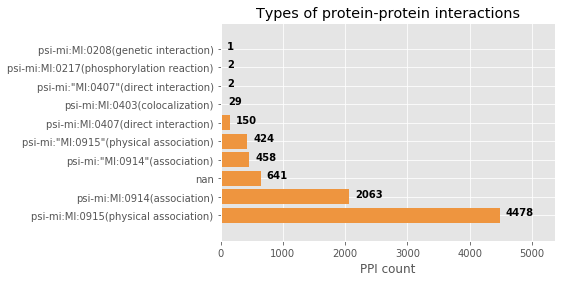

In [14]:
height = df_herpes['interaction_type'].value_counts(dropna=False)
bars = height.index
y_pos = np.arange(len(bars))
plt.barh(y_pos, height, color=('#ee953f'))
plt.yticks(y_pos, bars)
for i in range(len(y_pos)):
    plt.text(x = height[i]+100 , y = y_pos[i], s = height[i], size = 10, fontweight = 'bold')
plt.margins(0.2, 0.1)
plt.title('Types of protein-protein interactions')
plt.xlabel('PPI count')
plt.savefig('../../data/processed/img/interaction-types.pdf', facecolor='#fafafa', edgecolor='none', bbox_inches='tight')
plt.show()

Less than half of all interactions have been assigned a confidence score.

In [15]:
df_herpes[df_herpes.confidence_score.str.contains('miscore', na=False)].shape[0] / df_herpes.shape[0]

0.4742967992240543

The possible values are:

In [16]:
print([i for i in pd.unique(df_herpes.confidence_score.str.split(':').str.get(0))])

['intact-miscore', '-', 'virhostnet-miscore', nan]


Scores of the format `author score:3.57|intact-miscore:0.37` are also permitted by the PSI-MITAB format, but none of these were present for this specific subset.

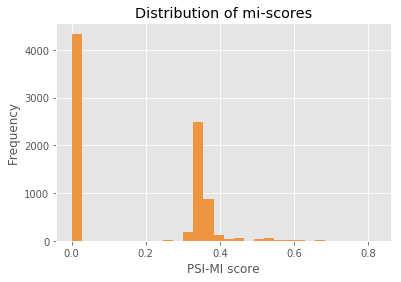

In [17]:
pd.to_numeric(df_herpes.confidence_score.str.split(':').str.get(1).fillna(0)).plot(kind='hist', bins=30, color=('#ee953f', '#23373b'))
plt.title('Distribution of mi-scores')
plt.xlabel('PSI-MI score')
plt.savefig('../../data/processed/img/mi-score-dist.pdf', facecolor='#fafafa', edgecolor='none', bbox_inches='tight')
plt.show()

### Taxonomic diversity of data set

The final data set consists of 8248 unique PPI between Herpesviridae and the following hosts. As expected, human interaction make up the bulk of this data set (7494 out of the 8248 PPIs). The majority of hosts are only represented by one or two PPIs.
Also, there seems to be one entry describing an interaction between *Arabidopsis* and Human Herpes Simplex Virus 1, which does not represent a naturally occurring interaction, but rather an experimental gene silencing method (https://www.ncbi.nlm.nih.gov/pubmed/25150167). 

In [18]:
all_taxids = df_herpes['taxid_A'].append(df_herpes['taxid_B']).unique()
host_taxids = list(np.setdiff1d(all_taxids, herpes_taxids))
host_list = []
for i in host_taxids:
    taxid = i.split(':')[1]
    count = df_herpes['xref_partners_sorted'].loc[(df_herpes['taxid_A'] == i) | (df_herpes['taxid_B'] == i)].shape[0]
    host_list.append({'Taxid' : taxid, 'Name' : taxid2name[taxid], 'Count' : count, 'Log count' : np.log10(count)})
host_df = pd.DataFrame(host_list).sort_values('Count', ascending=False)
display(host_df)
reorder_pathogen_host_entries(df_herpes, host_taxids)

,Count,Log count,Name,Taxid
21,7494,3.874714,Homo sapiens,9606
1,58,1.763428,Rattus norvegicus,10116
0,29,1.462398,Mus musculus,10090
24,23,1.361728,Bos taurus,9913
7,9,0.954243,Janthinobacterium sp. Marseille,375286
16,7,0.845098,Gallus gallus,9031
10,6,0.778151,Lactobacillus crispatus ST1,748671
22,6,0.778151,Equus caballus,9796
23,4,0.602060,Sus scrofa,9823
20,4,0.602060,Pongo abelii,9601


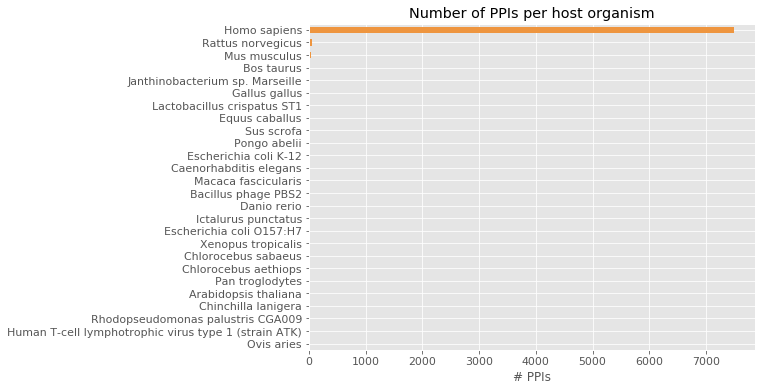

In [25]:
host_df.sort_values('Log count').plot(x='Name',y='Count', kind="barh", color=('#ee953f'), 
                                      legend=False, width=0.5,figsize=(8, 6), fontsize=11)
# plt.tight_layout()
plt.title('Number of PPIs per host organism')
plt.xlabel(r'# PPIs')
# plt.xlabel(r'$\log$ (# PPIs)')
plt.ylabel('')
plt.savefig('../../data/processed/img/taxonomic-diversity.pdf', facecolor='#fafafa', edgecolor='none', bbox_inches='tight')
plt.show()

In [26]:
herpes_taxids = list(np.setdiff1d(all_taxids, host_taxids))
pathogen_list = []
for i in herpes_taxids:
    taxid = i.split(':')[1]
    count = df_herpes['xref_partners_sorted'].loc[(df_herpes['taxid_A'] == i) | (df_herpes['taxid_B'] == i)].shape[0]
    pathogen_list.append({'Taxid' : taxid, 'Name' : taxid2name[taxid], 'Count' : count})
path_df = pd.DataFrame(pathogen_list).sort_values('Count', ascending=False)
display(path_df)

,Count,Name,Taxid
25,2265,Human herpesvirus 4 strain B95-8,10377
50,2217,Epstein-barr virus strain ag876,82830
1,863,Herpes simplex virus (type 1 / strain 17),10299
44,791,Human gammaherpesvirus 8,37296
24,518,Human gammaherpesvirus 4,10376
41,411,Murid gammaherpesvirus 4,33708
53,264,Human herpesvirus 8 strain GK18,868565
46,199,Human herpesvirus 8 type M,435895
20,177,Murid betaherpesvirus 1,10366
14,168,Human alphaherpesvirus 3,10335


The viruses were also mapped to a higher taxonomic grouping for clarity.

In [27]:
taxid_nodes_path = Path(r'../../data/raw/taxdump/nodes.dmp')
taxid2parent, taxid2rank = retrieve_taxids.parse_taxid_nodes(str(taxid_nodes_path))
parent2child = retrieve_taxids.create_parent2child_dict(taxid2parent)
pathogen_group_dict = {'bovine_ah1': '10320', 'bovine_hv1': '79889', 'epstein_barr': '10376', 'equid_av1': '10326',
                       'equid_gv2': '12657', 'gallid_av2': '10390', 'human_hsv1': '10298', 'saimiri_gv2': '10381',
                       'human_av2': '10310', 'human_av3': '10335', 'human_bv5': '10359', 'human_gv8': '37296',
                       'human_bv6A': '32603', 'human_bv6B': '32604', 'murid_bv1': '10366', 'murid_gv4': '33708',
                       'papiine_gv1': '106332', 'suid_av1': '10345', 'bovine_gv4': '10385', 'ateline_gv3': '85618', 
                       'elephantid_bv1': '146015'}

for i, j in pathogen_group_dict.items():
    pathogen_group_dict[i] = [j] + retrieve_taxids.get_children(j, parent2child)

df_herpes['pathogen_groups'] = df_herpes.apply(lambda x: pathogen_group_mapper(x['taxid_B'].split(':')[1],
                                                                               pathogen_group_dict), axis=1)

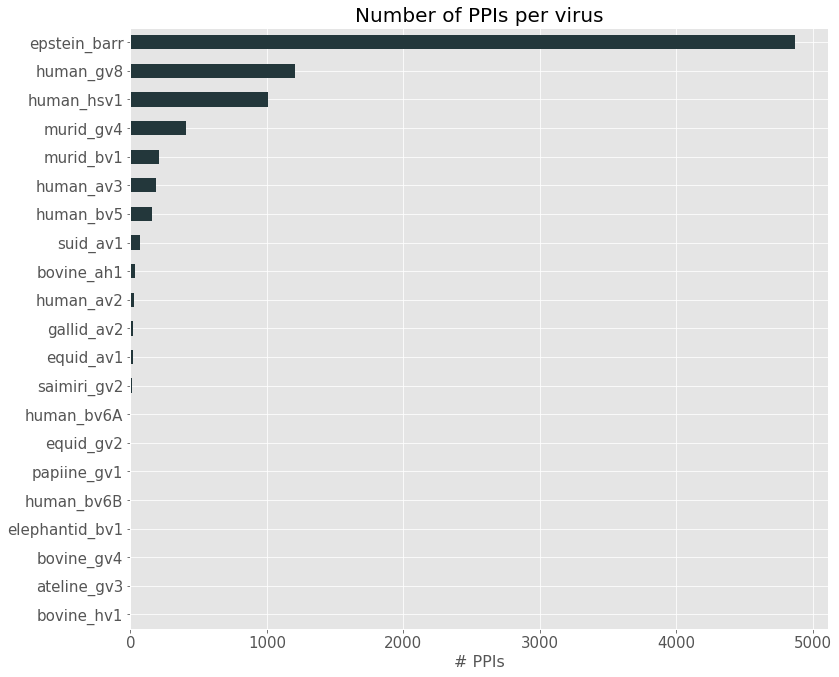

In [36]:
pathogen_higher_list = []
for i in pathogen_group_dict:
    taxid = pathogen_group_dict[i]
    count = df_herpes['xref_partners_sorted'].loc[(df_herpes['pathogen_groups'] == i)].shape[0]
    pathogen_higher_list.append({'Taxid' : taxid, 'Name' : i, 'Count' : count})
pathogen_higher_df = pd.DataFrame(pathogen_higher_list).sort_values('Count', ascending=False)
pathogen_higher_df.sort_values('Count').plot(x='Name',y='Count', color=('#23373b'), kind="barh", 
                                             legend=False, width=0.5,figsize=(12, 9), fontsize=15)
plt.tight_layout()
plt.title('Number of PPIs per virus', fontsize=20)
plt.xlabel('# PPIs', fontsize=16)
# plt.ylabel('Herpes virus',fontsize=16)
plt.ylabel('')
plt.savefig('../../data/processed/img/pathogen-diversity.pdf', facecolor='#fafafa', edgecolor='none', bbox_inches='tight')
plt.show()
# https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size-in-matplotlib

Lastly, it should be noted that the presence of a certain pathogen does not imply that its PPI partners originate from its natural host. For example, the single entry for the ateline gamme herpes virus 3 actually consists of an interaction with a human protein.

In [29]:
df_herpes.loc[df_herpes.pathogen_groups=='ateline_gv3']

,Annotation(s) interactor A,Annotation(s) interactor B,Biological role(s) interactor A,Biological role(s) interactor B,Checksum(s) interactor A,Checksum(s) interactor B,Creation date,Expansion method(s),Experimental role(s) interactor A,Experimental role(s) interactor B,Feature(s) interactor A,Feature(s) interactor B,Host organism(s),Identification method participant A,Identification method participant B,Interaction Checksum(s),Interaction Xref(s),Interaction annotation(s),Interaction parameter(s),Negative,Stoichiometry(s) interactor A,Stoichiometry(s) interactor B,Type(s) interactor A,Type(s) interactor B,Update date,Xref(s) interactor A,Xref(s) interactor B,aliases_A,aliases_B,alt_identifiers_A,alt_identifiers_B,author,confidence_score,detection_method,display_id_A,display_id_B,interaction_identifiers,interaction_type,origin,pathogen,protein_seq1,protein_seq2,protein_taxid_1_cat,protein_taxid_1_name,protein_taxid_2_cat,protein_taxid_2_name,protein_xref_1_display_id,protein_xref_1_unique,protein_xref_2_display_id,protein_xref_2_unique,publication,source_database,source_database_ids,taxid_A,taxid_B,xref_A,xref_B,xref_partners_sorted,inter-intra,pathogen_groups
1287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,psi-mi:lck_human(display_long)|uniprotkb:Protein YT16(gene name synonym)|uniprotkb:Proto-oncogene Lck(gene name synonym)|uniprotkb:T cell-specific protein-tyrosine kinase(gene name synonym)|unipro...,psi-mi:tio_athv3(display_long),intact:EBI-1348|uniprotkb:Q7RTZ3|uniprotkb:D3DPP8|uniprotkb:Q96DW4|uniprotkb:Q9NYT8|uniprotkb:P07100|uniprotkb:Q12850|uniprotkb:Q13152|uniprotkb:Q5TDH8|uniprotkb:Q5TDH9,intact:EBI-7709835|intact:MINT-7301078,Albrecht et al. (2005),intact-miscore:0.40,psi-mi:MI:0007(anti tag coimmunoprecipitation),NaN,NaN,intact:EBI-7709844|mint:MINT-7301088,psi-mi:MI:0915(physical association),hpidb2,NaN,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRDPLVTYEGSNPPASPLQDNLVIALHSYEPSHDGDLGFEKGEQLRILEQSGEWWKAQSLTTGQEGFIPFNFVAKANSLEPEPWFFKNLSRKDAERQLLAPGNTHGSFLIRESESTAGSFSLSVRDFDQNQGEVVKHYKIRNLDNGGFYISPR...,MANEPQEHEEGKPFFPPLGDSGEEGPPNIPQDPTPGTPPGPINSKNEDYPPPLENPGPNKSEGPPDGSGNSSPPVTMLVKNNGDRTKQDVSESGGNNSAPNSVESKHTSSSSSAGNGNETKCPDEQNTQECITTIYIPWEDAKPKLMGLVKLDSSDSEEERSPFNKYPKNYKKLRVDMGENWPPGIPPPQLPPRPA...,ANIMAL,human|Homo sapiens,VIRUS,athv-3|Ateline herpesvirus 3,LCK_HUMAN,UNIPROT_AC:P06239,TIO_ATHV3,UNIPROT_AC:Q9YJQ8,pubmed:16051843|mint:MINT-7216142|doi:10.1128/JVI.79.16.10507-10513.2005,MINT,psi-mi:MI:0471(MINT),taxid:9606,taxid:85618,uniprotkb:P06239,uniprotkb:Q9YJQ8,uniprotkb:P06239%uniprotkb:Q9YJQ8,inter-species,ateline_gv3


#### Inter-viral interactions

As was mentioned above, this data set only contains PPIs between different organisms, i.e. our intent was to collect host-pathogen interactions. To this end we merely filtered out interactions where both protein partners belonged to the same organism. However, 186 PPIs are actually interactions between two different viruses. Interestingly, the converse (PPIs between two hosts) never occurred.

In [ ]:
print('Number of inter-viral PPIs:', df_herpes.loc[(df_herpes.taxid_A.isin(herpes_taxids) & df_herpes.taxid_B.isin(herpes_taxids)),:].shape[0])
print('Number of inter-host PPIs:', df_herpes.loc[~(df_herpes.taxid_A.isin(herpes_taxids) | df_herpes.taxid_B.isin(herpes_taxids)),:].shape[0])

This also means that there could be an overlap between the two columns of protein partners, and more importantly, partner A in each interaction isn't necessarily a host. Indeed, there seem to be 35 offending viral proteins in the A column. This was remedied by pruning any PPIs with viral taxids in both columns. 

In [ ]:
print('Combined count of both protein columns', len(df_herpes.xref_A.unique()) + len(df_herpes.xref_B.unique()))
b = set(df_herpes.xref_A.unique())
b.update(df_herpes.xref_B.unique())
print('Unique proteins after aggregating', len(b))
# print(len(np.unique(np.append(df_herpes.xref_A.values, df_herpes.xref_B.values))))
selection = ~(df_herpes.taxid_A.isin(herpes_taxids) & df_herpes.taxid_B.isin(herpes_taxids))
df_herpes = df_herpes.loc[selection]
df_herpes.reset_index(inplace=True)

### Protein diversity

In [ ]:
# protein_set = set(df_herpes.xref_A.append(df_herpes.xref_B, ignore_index=True).str.extract('^.*:(\w*)-?',expand=False).unique())
# viral_protein_set = set(df_herpes.xref_A[df_herpes.taxid_A.isin(herpes_taxids)].append(df_herpes.xref_B[df_herpes.taxid_B.isin(herpes_taxids)], ignore_index=True).str.extract('^.*:(\w*)-?',expand=False).unique())
# host_protein_set = set(df_herpes.xref_A[df_herpes.taxid_A.isin(host_taxids)].append(df_herpes.xref_B[df_herpes.taxid_B.isin(host_taxids)], ignore_index=True).str.extract('^.*:(\w*)-?',expand=False).unique())
# height = [len(x) for x in [protein_set, viral_protein_set, host_protein_set]]
# bars = ['Total','Viral','Host']
# y_pos = np.arange(len(bars))
# plt.barh(y_pos, height, color=('#ee953f'))
# plt.yticks(y_pos, bars)
# for i in range(len(y_pos)):
#     plt.text(x = height[i]+100 , y = y_pos[i], s = height[i], size = 10, fontweight = 'bold')
# plt.margins(0.2, 0.1)
# plt.title('Total protein diversity')
# plt.xlabel('# proteins')
# plt.savefig('../../data/processed/img/protein-diversity.pdf', facecolor='#fafafa', edgecolor='none', bbox_inches='tight')
# plt.show()

protein_set = set(df_herpes.xref_A.append(df_herpes.xref_B, ignore_index=True).str.extract('^.*:(\w*)-?',expand=False).unique())
viral_protein_set = set(df_herpes.xref_A[df_herpes.taxid_A.isin(herpes_taxids)].append(df_herpes.xref_B[df_herpes.taxid_B.isin(herpes_taxids)], ignore_index=True).str.extract('^.*:(\w*)-?',expand=False).unique())
host_protein_set = set(df_herpes.xref_A[df_herpes.taxid_A.isin(host_taxids)].append(df_herpes.xref_B[df_herpes.taxid_B.isin(host_taxids)], ignore_index=True).str.extract('^.*:(\w*)-?',expand=False).unique())
height = [len(x) for x in [viral_protein_set, host_protein_set]]
bars = ['Viral','Host']
y_pos = np.arange(len(bars))
plt.barh(y_pos, height, color=('#ee953f', '#23373b'))
plt.yticks(y_pos, bars)
for i in range(len(y_pos)):
    plt.text(x = height[i]+100 , y = y_pos[i], s = height[i], size = 10, fontweight = 'bold')
plt.margins(0.2, 0.1)
plt.title('Total protein diversity')
plt.xlabel('# proteins')
plt.savefig('../../data/processed/img/protein-diversity.pdf', facecolor='#fafafa', edgecolor='none', bbox_inches='tight')
plt.show()

## Annotation data

All of the PPIs were labeled with two types of meta-data, which will be used for the subsequent frequent item set mining methods later in the analysis. The annotation data that was used for the labeling was Gene Ontology (GO) and InterPro domain information for both partners in a PPI.

### Gene Ontology

Each protein in the PPI data set was labeled with its GO terms. All three namespaces were used: _biological process_, _molecular function_ and _cellular component_.

In [ ]:
%%capture
go_dict = obo_tools.importOBO(r'../../data/raw/go_data/go.obo')
obo_tools.buildGOtree(go_dict, root_nodes=['GO:0008150', 'GO:0005575', 'GO:0003674'])
protein_set = set(df_herpes.xref_A.append(df_herpes.xref_B, ignore_index=True).str.extract('^.*:(\w*)-?',expand=False).unique())
gaf_dict = gaf_parser.importGAF(r'../../data/raw/go_data/gene_association_hosts_10292.goa', protein_set)
label_go.annotate_GO(df_herpes, gaf_dict)

114 proteins lacked any GO terms, the majority of which were viral (84), which was to be expected.

In [ ]:
not_annotated = [i for i in protein_set if i not in gaf_dict]
print(len(not_annotated), 'proteins lacked GO terms.')
a_multiset = collections.Counter(not_annotated)
b_multiset = collections.Counter(viral_protein_set)
overlap = list((a_multiset & b_multiset).elements())
print(len(overlap), 'proteins were of viral origin.')

To reduce redundancy, all GO terms were remapped upwards to a specific depth. I.e. terms were made less specific to reduce the amount of unique terms. This *lower resolution* makes sense in this context because our ultimate goal was to find general similarities between various PPIs. If extremely specific labels were considered, very few frequently co-occurring terms would be found during the item set mining step of this analysis.

The following depths were selected, while excluding a number of terms that were deemed *too general*. We understand that this selection of terms seems arbitrary, but unfortunately the nature of the GO hierarchy does not lend itself to strict cut-offs. Indeed, the semantic content of a term with a depth of 4 in one branch, might be much higher than a term with depth 6 in another branch. Moreover, terms can have different depths depending on which branch is considered.

Note: the minimal depth was always assigned here. The depth of the root node was set to zero.

    A more nuanced approach would be to look at the information content of nodes to decide whether or not they should be included or excluded. See Alterovitz et al. (2007) and Mazandu & Mulder (2014) for more information. 

In [ ]:
%%capture
test_set_not = []
test_set_in = []
depth = {'biological_process': 2, 'molecular_function': 1, 'cellular_component': 1}
exclusion = {'GO:0005623': 'cell', 'GO:0005488': 'binding', 'GO:0043226': 'organelle',
                 'GO:0044422': 'organelle part', 'GO:0044464': 'cell part', 'GO:0033643': 'host cell part',
                 'GO:0033646': 'host intracellular part', 'GO:0043656': 'intracellular region of host',
                 'GO:0043657': 'host cell', 'GO:0018995': 'host', 'GO:0044424': 'intracellular part',
                 'GO:0016032': 'viral process', 'GO:0019058': 'viral life cycle',
                 'GO:0044215': 'other organism',
                 'GO:0050789': 'regulation of biological process', 'GO:0005515': 'protein binding',
                 'GO:0009987': 'cellular process',
                 'GO:0052173': 'response to defenses of other organism involved in symbiotic interaction'}
label_go.remap_GO_depth(df_herpes, depth, go_dict, test_set_not, test_set_in, list(exclusion))
label_host_pathogen(df_herpes, herpes_taxids, columns=['xref_A_GO', 'xref_B_GO'],taxid_columns=['taxid_A', 'taxid_B'])

### InterPro

In addition to the GO labels, InterPro functional information was appended to the data. This includes: `homologous superfamilies`, `families`, `domains`, `repeats` and `sites`.

In [ ]:
unique_ac = set(pd.unique(df_herpes['xref_B'].str.extract('^.*:(\w*)-?', expand=False).append(df_herpes['xref_A'].str.extract('^.*:(\w*)-?', expand=False), ignore_index=True)))
uniprot2interpro = label_interpro.create_uniprot2interpro_dict(unique_ac, filepath=r'../../data/interim/interpro_data/protein2ipr_filtered.txt')
label_interpro.annotate_interpro(df_herpes, uniprot2interpro)
label_host_pathogen(df_herpes, herpes_taxids, columns=['interpro_A', 'interpro_B'], taxid_columns=['taxid_A', 'taxid_B'])

## Examining the resulting data

The final data set had the following format. It is a transaction-like format commonly used for frequent item set mining. Each _transaction_ (protein-protein interaction) consists of several _items_ (GO and InterPro terms). Note that a prefix-marker indicates to which partner in the interaction the annotation label is referring to.

In [ ]:
df_herpes[['xref_A', 'xref_B', 'pathogen_groups', 'xref_A_GO', 'xref_B_GO', 'interpro_A', 'interpro_B']].head(6)

We can visualise the average annotation level across the different viral groups by counting the number of distinct GO and InterPro terms per PPI and averaging them. It is immediately obvious that the host proteins are described more thoroughly than the viral ones. The GO information is also more extensive than InterPro.

In [ ]:
def get_annotation_size(df, column):
    size = df[column].str.split(',')
    size[size.notna()] = size[size.notna()].apply(lambda x: len(x))
    size = size.fillna(0)
    return size

df_herpes['xref_A_GO_size'] = get_annotation_size(df_herpes, 'xref_A_GO')
df_herpes['xref_B_GO_size'] = get_annotation_size(df_herpes, 'xref_B_GO')
df_herpes['interpro_A_size'] = get_annotation_size(df_herpes, 'interpro_A')
df_herpes['interpro_B_size'] = get_annotation_size(df_herpes, 'interpro_B')
df_herpes['total_label_size'] = df_herpes['xref_A_GO_size'] + df_herpes['xref_B_GO_size'] + df_herpes['interpro_A_size'] + df_herpes['interpro_B_size']

df_size = df_herpes[['xref_A_GO_size', 'xref_B_GO_size', 'interpro_A_size', 'interpro_B_size']]
df_size.columns=['Host GO', 'Virus GO', 'Host InterPro', 'Virus InterPro']
df_size.mean().plot(kind='barh',color=('#ee953f'))
plt.tight_layout()
plt.title('Average number of GO and InterPro annotations for human and viral proteins.')
plt.xlabel('Number of annotations')
plt.savefig('../../data/processed/img/annotation-diversity1.pdf', facecolor='#fafafa', edgecolor='none', bbox_inches='tight')

plt.show()

df_herpes.groupby('pathogen_groups')['total_label_size'].mean().plot(kind='barh',width=0.5,figsize=(10, 5),color=('#ee953f'))
plt.tight_layout()
plt.title('Average number of combined annotations for all PPIs across viral groups.')
plt.xlabel('Number of annotations')
plt.ylabel('')
plt.savefig('../../data/processed/img/annotation-diversity2.pdf', facecolor='#fafafa', edgecolor='none', bbox_inches='tight')
plt.show()

There are a total of 4704 unique values using this remapping.

In [ ]:
pd.unique(df_herpes[['xref_A_GO', 'xref_B_GO', 'interpro_A', 'interpro_B']].values.ravel()).shape

## Some caveats...

- **Redundancy**: GO annotation is often based on InterPro data (https://www.ebi.ac.uk/interpro/about.html).
- **Data imbalance**: both in distribution of hosts and viruses.
- **Breadth of inference**: only binary interactions are considered, i.e. the bigger scope, such as complexes or pathways/chains of interactors, is ignored.
- **Primary data accuracy**: PPIs are notorious for false positives. Many different experimental methods are combined. Some databases split information about protein complexes into inferred binary associations while this might not be the case. Etc.
- The **remapping of GO terms** might be a bit crude:
    - Semi-arbitrary exclusion list.
    - Different approaches for remapping: map everything to same depth, but keep lower depth if already there. Map everything to same depth AND lower depth? Will lead to enrichment of lower terms...
    - Aren't retrieved GO terms redundant already in some cases?
    - Only _is a_ relations were considered, but _part of_ might be better. This would complicate the mapping across namespaces though.

## Potential improvements in data filtering and validation

A number of PSI-MI controlled vocabulary terms could be used for more stringent data filtering, however, not all of these are available for the PHISTO dataset (although this might not be a large problem due to how much it overlaps with the other datasets).

- Interaction confidence score (https://www.ebi.ac.uk/ols/ontologies/MI/terms?obo_id=MI:1064)
- Interaction detection method (https://www.ebi.ac.uk/ols/ontologies/MI/terms?obo_id=MI:0001)
- Interaction type (https://www.ebi.ac.uk/ols/ontologies/MI/terms?obo_id=MI:0190)

See also: 
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4316181/
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3394291/

# Frequent item set mining

After collecting and preparing the data, a frequent item set mining algorithm was employed to generate association rules. The most important topic to highlight here, is the fact that only association rules with *uniform* antecedents and consequents. By this we mean that the set of items on either side of the rule must be completely made up of one type of label, either host or viral. E.g. rules were of the type `viral, viral -> host, host, host` or `host -> viral`.

**Whether this is the best choice is hard to prove**, although by restricting the rules to this subset, the biological meaning becomes easier to grasp. Indeed, these rules will describe patterns intrinsically part of the interplay between the hosts and pathogens.

**TODO: Add some information about the algorithm here...likely apriori?**

The other mining parameters were as follows:

- minimum support: 1%
- minimum confidence: 70%
- maximum transaction size: 3

Due to memory limitations, the item set mining had to be restricted to items of size 3. Increasing this to 4 took over 12 hours on the HPC facility and the job was terminated. Another run with a minimum item set size of 5 required more than the 60 GB that was available.

For each rule, the *confidence* and *lift* measures were calculated:

$\mathrm{conf}(X \Rightarrow Y) = \frac{\mathrm{supp}(X \cup Y)}{\mathrm{supp}(X)}$ 

$ \mathrm{lift}(X\Rightarrow Y) = \frac{ \mathrm{supp}(X \cup Y)}{ \mathrm{supp}(X) \times \mathrm{supp}(Y) } $ 

## Creation of pairwise sub-rules

All the generated association rules were condensed into their constituting *pairwise sub-rules*. 

For example, a rule such as 

`v@GO0033644,v@GO0033655>h@GO0043227;0.7925608011444921;0.6410228315611889`

was split into the pairwise rules 

`v@GO0033644>h@GO0043227` and `v@GO0033655>h@GO0043227`.

During this process the mean and maximum confidence and lift were stored for each sub-rule.

## Visualisation of association rules

The following network summarises all pairwise sub-rules, after removal of uninformative generic terms. These rules represent frequent (support > 3%) patterns in the properties of PPIs between *Herpesviridae* and their hosts. For a larger figure, [click here](https://raw.githubusercontent.com/pmoris/host-pathogen-ppi-fim/restructure/poster/graph_rules_600dpi_5.png).

In [ ]:
display(Image(filename="../../poster/graph_rules_600dpi_5.png", width=900, height=1500, unconfined=True))

# Some more caveats

- The association rule mining only considered rules going from a pure viral/host item set to another one. Perhaps allowing mixed item sets as well.
- Parameter tweaks for confidence, maximum item set size and frequency might improve/change the results.
- **Reducing the association rules back to binary interactions seems a bit counter-productive!**
    - Moreover, the manner in which this is done might be hard to justify. I.e. we associate the maximum confidence found among a sub-set of rules, with the derived binary rule.
- Removal of uninformative pairwise-sub rules is a bit arbitrary. 

# Some more unexplored options

- Tweaking support / confidence thresholds
- Repeat for distinct groups e.g. Epstein-Barr, HSV-1, HGV8
- Also do GO enrichment (comparable to [Durmuş & Ülgen 2017](http://onlinelibrary.wiley.com/doi/10.1002/2211-5463.12167))
- Subgraph mining


# References
- Ammari, Mais G., Cathy R. Gresham, Fiona M. McCarthy, and Bindu Nanduri. 2016. "HPIDB 2.0: A Curated Database For Host–Pathogen Interactions". Database 2016: baw103. doi:10.1093/database/baw103.
- Guirimand, T., S. Delmotte, and V. Navratil. 2014. "Virhostnet 2.0: Surfing On The Web Of Virus/Host Molecular Interactions Data". Nucleic Acids Research 43 (D1): D583-D587. doi:10.1093/nar/gku1121.
- Durmuş Tekir, Saliha, Tunahan Çakır, Emre Ardıç, Ali Semih Sayılırbaş, Gökhan Konuk, Mithat Konuk, and Hasret Sarıyer et al. 2013. "PHISTO: Pathogen–Host Interaction Search Tool". Bioinformatics 29 (10): 1357-1358. doi:10.1093/bioinformatics/btt137.
- Smith, Barry, Michael Ashburner, Cornelius Rosse, Jonathan Bard, William Bug, Werner Ceusters, and Louis J Goldberg et al. 2007. "The OBO Foundry: Coordinated Evolution Of Ontologies To Support Biomedical Data Integration". Nature Biotechnology 25 (11): 1251-1255. doi:10.1038/nbt1346.
- Alterovitz, Gil, Michael Xiang, Mamta Mohan, and Marco F. Ramoni. 2006. "GO Pad: The Gene Ontology Partition Database". Nucleic Acids Research 35 (suppl_1): D322-D327. doi:10.1093/nar/gkl799.
- Mazandu, Gaston K., and Nicola J. Mulder. 2014. "Information Content-Based Gene Ontology Functional Similarity Measures: Which One To Use For A Given Biological Data Type?". Plos ONE 9 (12): e113859. doi:10.1371/journal.pone.0113859.

In [ ]:
import requests, sys, json

requestURL = "https://www.ebi.ac.uk/proteins/api/proteins?offset=0&size=100&reviewed=true&taxid=10298%2C946522%2C10299%2C10300%2C10301%2C10302%2C37106%2C10304%2C744249%2C10303%2C10305%2C10306%2C37107%2C10307%2C10308%2C36345%2C36346%2C10309"
r = requests.get(requestURL, headers={ "Accept" : "application/json"})

if not r.ok:
  r.raise_for_status()
  sys.exit()

responseBody = r.text
j = json.loads(responseBody)

In [ ]:
len(j)

In [ ]:
j[0].keys()